In this notebook I will be completing a test of Simulation Scenario 1. To begin let us load the x and y data that I collected from the R package.

In [1]:
import pandas as pd

datax = pd.read_csv("data/sim1/sim_datax.csv")
datay = pd.read_csv("data/sim1/sim_datay.csv")


Now I will plot the raw X and Y data found in the files.

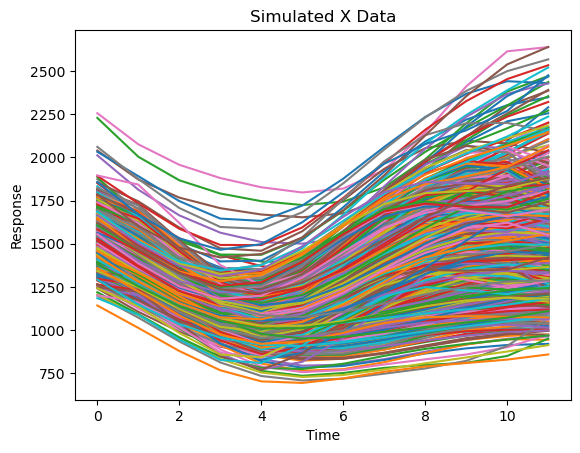

In [2]:
import matplotlib.pyplot as plt

for row in datax.values:
    plt.plot(row)
plt.title("Simulated X Data")
plt.xlabel("Time")
plt.ylabel("Response")
plt.show()

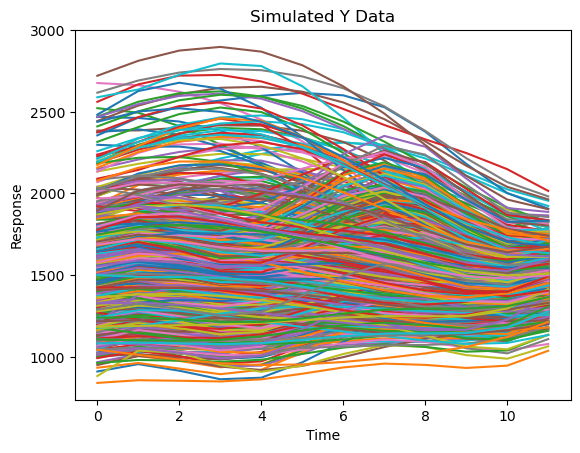

In [3]:
for row in datay.values:
    plt.plot(row)

plt.title("Simulated Y Data")
plt.xlabel("Time")
plt.ylabel("Response")
plt.show()

Now I will convert this data to functional data. I will compare a Fourier basis and B-Spline basis before selecting which kind represents the data the most accurately.

In [4]:
from process_data import create_functional_data

#Fourier is the default basis
fourier_datax = create_functional_data(datax)
bspline_datax = create_functional_data(datax, basis_type="BSPLINE", n_basis=50)



Since both BSpline and Fourier bases do not represent the data well, I will use Least Squares to see if we can get a better approximation of our curves. We will evaluate each data point on our original domain, except have 100 points from 1-12 instead of just 12 points.

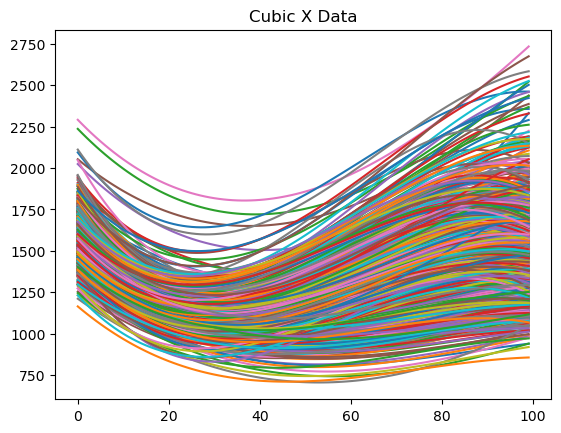

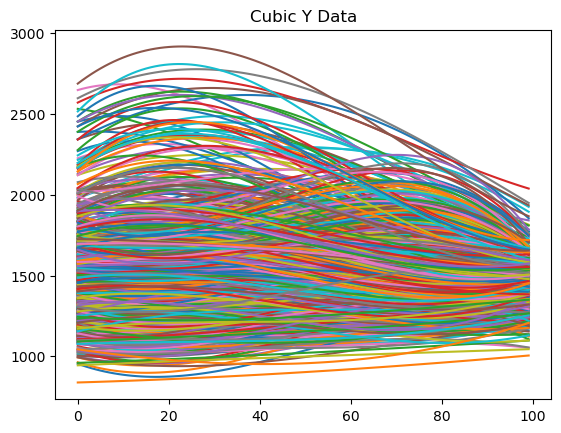

In [5]:
import numpy as np

x = np.linspace(0, 1, 12)
x_dense = np.linspace(0, 1, 100)

y = np.arange(13, 25, 1)

#I will be fitting to a cubic function
new_datax = []
new_datay = []

for row in datax.values:
   
    coeffs_x = np.polyfit(x, row, deg=3)
    evaluated_row_x = np.polyval(coeffs_x, x_dense)
    new_datax.append(evaluated_row_x)

for row in datay.values: 

    coeffs_y = np.polyfit(x, row, deg=3)
    evaluated_row_y = np.polyval(coeffs_y, x_dense)
    new_datay.append(evaluated_row_y)

new_datax = np.array(new_datax)
new_datay = np.array(new_datay)

for row in new_datax:
    plt.plot(row)

plt.title("Cubic X Data")
plt.show()


for row in new_datay:
    plt.plot(row)
plt.title("Cubic Y Data")
plt.show()

Now I'm going to create functional data objects based off of this data to plug into FunWeightClust

Text(0.5, 1.0, 'BSpline Y Data')

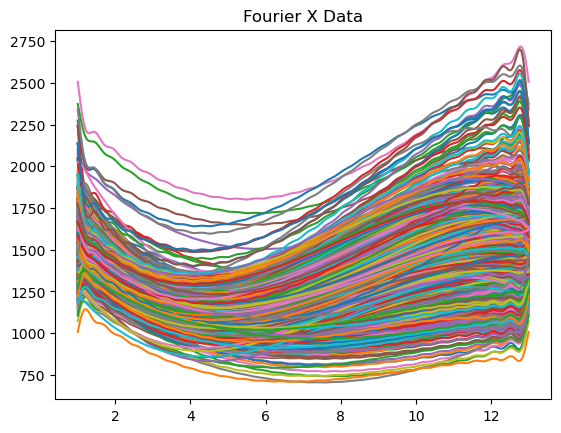

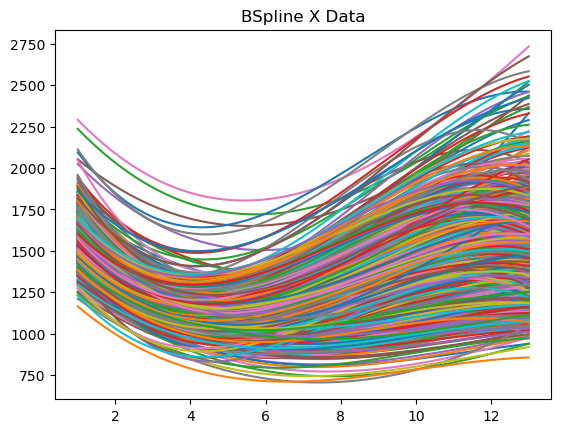

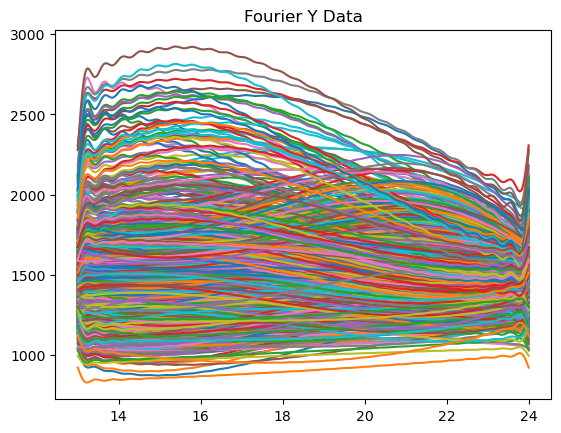

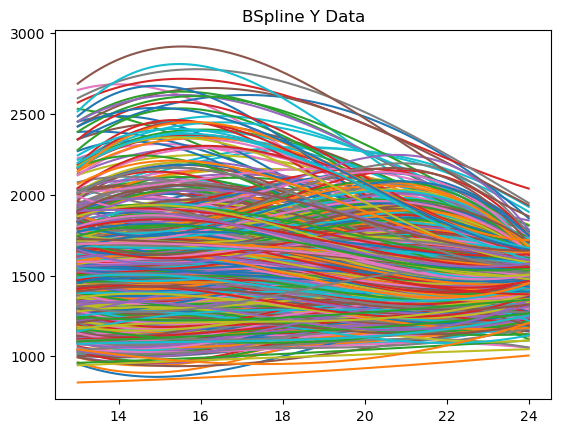

In [6]:
x_grid_points = np.linspace(1, 13, 100)
y_grid_points = np.linspace(13, 24, 100)

from skfda import FDataGrid
from skfda.representation.basis import FourierBasis, BSplineBasis

x_fourier = FDataGrid(data_matrix = new_datax, grid_points=x_grid_points).to_basis(FourierBasis(n_basis=50))
x_bspline = FDataGrid(data_matrix=new_datax, grid_points=x_grid_points).to_basis(BSplineBasis(n_basis=50))

x_fourier.plot()
plt.title("Fourier X Data")

x_bspline.plot()
plt.title("BSpline X Data")

y_fourier = FDataGrid(data_matrix=new_datay, grid_points=y_grid_points).to_basis(FourierBasis(n_basis=50))
y_bspline = FDataGrid(data_matrix=new_datay, grid_points=y_grid_points).to_basis(BSplineBasis(n_basis=50))

y_fourier.plot()
plt.title("Fourier Y Data")

y_bspline.plot()
plt.title("BSpline Y Data")

From the graphs, it is evident that BSpline represents our data better, so we will use the BSpline in FunWeightClust

In [9]:
import sklearn.metrics as met
import funweightclust as fwc

#Some of the x models you can use are: "AKJBKQKDK","AKJBQKDK", "AKBKQKDK", "ABKQKDK", "AKBQKDK", "ABQKDK"
#Some of the y models you can use are: "EII", "VII", "EEI", "VEI", "EVI", "VVI", "EEE", "VEE", "EVE", "EEV", "VVE", "VEV","EVV","VVV" 

models = ["AKJBKQKDK","AKJBQKDK"]
modelsy = ["EII", "VII", "EEI", "VEI"]
res = fwc.funweightclust(x_bspline, y_bspline, K = 2, model=models, modely = modelsy, init="kmeans", nb_rep = 1, threshold = 0.001)

FunWeightClust:   2.8 mins  |  Approx. remaining:       0.0 secs  |    100% complete 

       Model ModelY  K Threshold Complexity            BIC
1   AKJBQKDK    VEI  2     0.001     447.00    -945,788.35
2   AKJBQKDK    VII  2     0.001     398.00    -957,673.45
3  AKJBKQKDK    EEI  2     0.001     447.00    -983,108.05
4   AKJBQKDK    EEI  2     0.001     446.00    -986,699.18
5  AKJBKQKDK    VEI  2     0.001     448.00    -986,793.37
6  AKJBKQKDK    EII  2     0.001     398.00    -989,056.98
7  AKJBKQKDK    VII  2     0.001     399.00    -996,798.05
8   AKJBQKDK    EII  2     0.001     397.00  -1,001,385.83

Selected model AKJBQKDK-VEI with 2 clusters

Selection Criterion: bic



Now I will plot the X and Y BSpline Bases with colours that correspond to the labels given by FunWeightClust.

Text(0.5, 1.0, 'Classified Y Fourier Data')

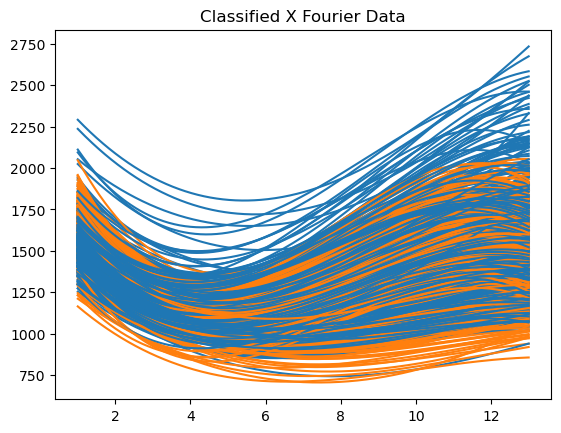

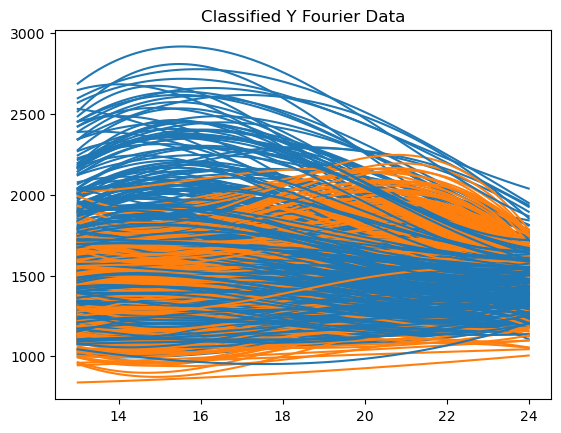

In [12]:
x_bspline.plot(group=res.cl)
plt.title("Classified X Fourier Data")
y_bspline.plot(group=res.cl)
plt.title("Classified Y Fourier Data")